In [140]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib            
print (matplotlib.rcParams['backend'])
%matplotlib --list


inline
Available matplotlib backends: ['agg', 'auto', 'cairo', 'gtk3', 'gtk3agg', 'gtk3cairo', 'gtk4', 'gtk4agg', 'gtk4cairo', 'inline', 'macosx', 'module://matplotlib_inline.backend_inline', 'nbagg', 'notebook', 'osx', 'pdf', 'pgf', 'ps', 'qt', 'qt5', 'qt5agg', 'qt5cairo', 'qt6', 'qtagg', 'qtcairo', 'svg', 'template', 'tk', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wx', 'wxagg', 'wxcairo']


In [132]:
def f(x):
    return 3*x**2 - 4 * x + 5

In [133]:
f(3.0)

20.0

In [117]:
xs = np.arange(-5, 5, 0.25)

In [118]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [119]:
ys = f(xs)

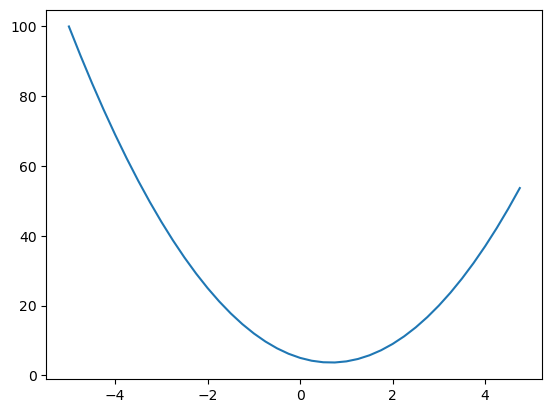

In [134]:
plt.plot(xs, ys)
plt.show()

In [135]:
h = 0.001
x = -3.0
(f(x+h)-f(x))/h

-21.996999999998934

In [122]:
# let's get a little more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [123]:
h = 0.0001

# inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [124]:
# as we mentioned neural networks will be pretty massive expressions

In [125]:
# we will need data structures that can hold this structure

In [126]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)
                          ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [138]:
from graphviz import Digraph


def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s| data %.4f | grad %.4f}" % (
            n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

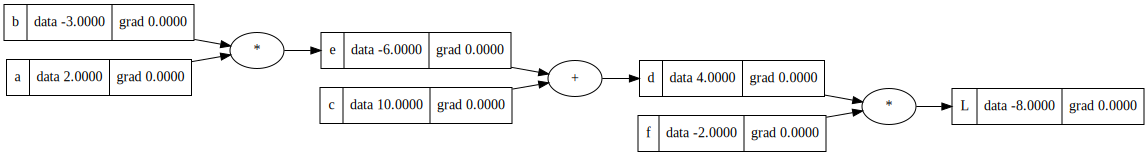

In [ ]:
draw_dot(L)

In [125]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d*f

print(L.data)

-8.0


In [126]:
def lol():
    # this is a gating function so as to not pollute the global scope
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'  # here we set the value of e and its label
    d = e + c
    d.label = 'd'  # python will internally call a.__add__(b)
    f = Value(-2.0, label='f')
    L = d*f
    L.label = 'L'
    L1 = L.data

    # this will be measuring the derivative of L with respect to a
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')

    e = a*b
    e.label = 'e'  # here we set the value of e and its label
    d = e + c
    d.label = 'd'  # python will internally call a.__add__(b)
    f = Value(-2.0, label='f')
    L = d*f
    L.label = 'L'
    L2 = L.data
    print((L2 - L1)/h)


lol()

-3.9999999999995595


In [127]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))

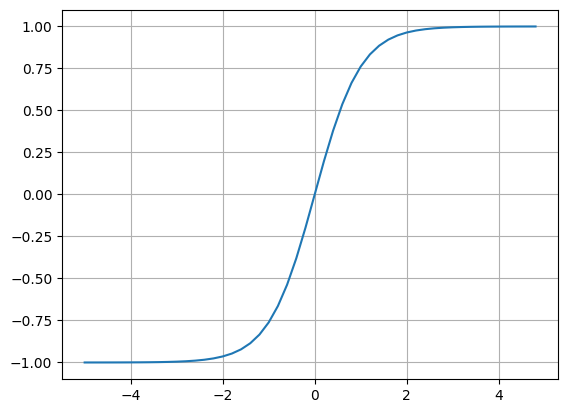

In [ ]:
plt.grid()

plt.show()

In [289]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')


# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 +bß
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

# tanh h is an exponentiation function, so we need to include exponentials.
o = n.tanh()
o.label = 'o'

o.backward()

In [130]:
draw_dot(o)

NameError: name 'draw_dot' is not defined

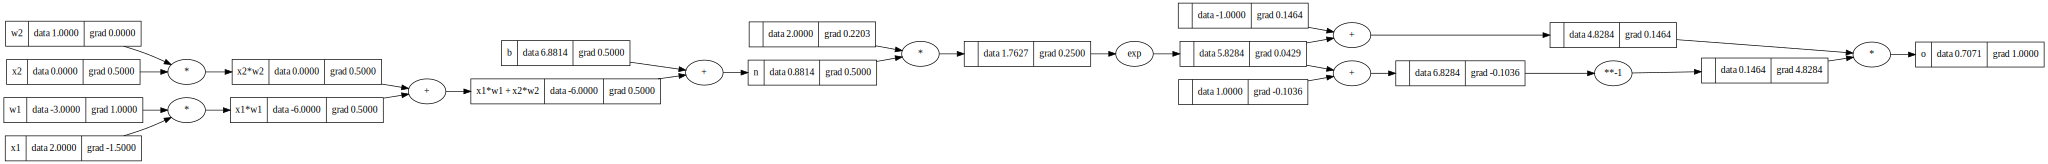

In [141]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [280]:
a = Value(2.0)
b = Value(4.0)

a - b

value(data=-2.0)

In [ ]:
import torch

In [14]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [142]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,  1))
                  for _ in range(nin)]  # w is a 2-d vector

        self.b = Value(random.uniform(-1,  1))  # b is just a scaler value?

    def __call__(self,  x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # print(act)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w+[self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin)
                        for _ in range(nout)]  # initializes neurons

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]  # get output values for out
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


x = [2.0, 3.0, 1.0]
n = MLP(3, [4, 4, 1])
n(x)

[3, 4, 4, 1]


Value(data=-0.3090098247496359)

In [144]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.19038903140911773),
 Value(data=-0.007653656143634201),
 Value(data=-0.3739922495482773),
 Value(data=-0.0906097829703491)]

In [149]:
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.9830927146004926)

In [150]:
loss.backward()
n.layers[0].neurons[0].w[0].grad

-1.2829088927851964